In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u

from astroquery.gaia import Gaia

Gaia.ROW_LIMIT = 100_000_000 # set this limit very high so we don't miss things

In [3]:
# determine cluster membership from gaia using the same algorithm as described
# in this paper (S2.1) https://academic.oup.com/mnras/article/532/2/2860/7708363#475484664
overwrite = True # this takes a little bit to run
cone_search_results_file = os.path.join(os.getcwd(),"gaia_cone_search_results.csv")

if overwrite:
    # first grab all gaia objects within 2 degrees of the cluster
    cluster_coord = SkyCoord(132.85, 11.81, unit=u.deg)
    cluster_radius = 2 * u.deg # 2 * u.deg
    
    job = Gaia.cone_search(cluster_coord, radius=cluster_radius)
    res = job.get_results().to_pandas()
    
    res.to_csv(cone_search_results_file)
else:
    res = pd.read_csv(cone_search_results_file, index_col=0)

res

,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist
0,1636148068921376768,Gaia DR3 604917625061651328,604917625061651328,780271500,2016.0,132.850541,0.055257,11.807407,0.031417,1.098415,...,0.1746,0.2141,0.1470,0.1318,0.1618,0.0776,0.0696,0.0855,MARCS,0.002640
1,1636148068921376768,Gaia DR3 604917629355038720,604917629355038720,489463705,2016.0,132.850311,0.013418,11.806078,0.007333,1.155961,...,0.0008,0.0035,0.0017,0.0007,0.0030,0.0009,0.0003,0.0016,MARCS,0.003928
2,1636148068921376768,Gaia DR3 604917629355039360,604917629355039360,67002387,2016.0,132.846938,0.042237,11.807362,0.024165,1.106578,...,0.3543,0.4048,0.3091,0.2877,0.3295,0.1661,0.1547,0.1771,MARCS,0.003994
3,1636148068921376768,Gaia DR3 604917629354073728,604917629354073728,935445147,2016.0,132.849023,0.545624,11.805028,0.240147,3.123763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.005059
4,1636148068921376768,Gaia DR3 604917629355038848,604917629355038848,509091296,2016.0,132.845425,0.012459,11.813721,0.007134,1.164408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.005830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75061,1636148068921376768,Gaia DR3 603825711229214080,603825711229214080,846594138,2016.0,134.638809,0.029832,10.848978,0.022546,2.786472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1.999947
75062,1636148068921376768,Gaia DR3 602285020559813376,602285020559813376,376747230,2016.0,131.099213,13.264194,12.846512,3.736587,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1.999951
75063,1636148068921376768,Gaia DR3 605556617408653952,605556617408653952,460316612,2016.0,134.007101,0.068562,13.460793,0.034797,2.126864,...,1.4273,1.5612,1.0894,1.0173,1.1181,0.5976,0.5575,0.6136,PHOENIX,1.999959
75064,1636148068921376768,Gaia DR3 608349617462171776,608349617462171776,884972565,2016.0,131.415984,0.134988,13.238400,0.066800,1.596674,...,0.5750,0.6410,0.4023,0.3818,0.4261,0.2481,0.2358,0.2624,MARCS,1.999984


In [4]:
def cluster_filter(
        cone_search_radius:float=2,
        minimum_radial_velocity:float=34-13.6, #km/s
        maximum_radial_velocity:float=34+13.6, #km/s
        minimum_parallax:float=1.15-0.12, 
        maximum_parallax:float=1.15+0.12,
        proper_motion_delta:float=0.7,
        proper_motion_ra:float=-11,
        proper_motion_dec:float=-2.9,
        overwrite=False
    ) -> pd.DataFrame:

    # read in the cleaned up M67 dataset
    res = pd.read_csv("gaia_cone_search_results.csv")
    
    # cone search cut
    cluster_coord = SkyCoord(132.85, 11.81, unit=u.deg)
    res_coord = SkyCoord(res.ra, res.dec, unit="deg")
    where_cluster = np.where(res_coord.separation(cluster_coord) < (cone_search_radius*u.deg))
    res = res.iloc[where_cluster]
    
    # radial velocity cut
    res = res[(res.radial_velocity > minimum_radial_velocity) * (res.radial_velocity < maximum_radial_velocity)]
    
    # parallax cut
    res = res[(res.parallax > minimum_parallax) * (res.parallax < maximum_parallax)]
    
    # proper motion cut
    dmu = proper_motion_delta # mas yr^-1; same units as gaia uses
    mu = np.array([proper_motion_ra, proper_motion_dec]) # mas yr^-1; same units as gaia uses
    
    proper_motion_distance = np.sqrt(np.sum((res[["pmra", "pmdec"]] - mu)**2, axis=1))
    res = res[proper_motion_distance <= dmu]
    
    if overwrite:
        res.to_csv("cleaned-M67-data.csv")

    return res



Text(0.5, 0, 'Gaia DR3 (BP - RP) Color')

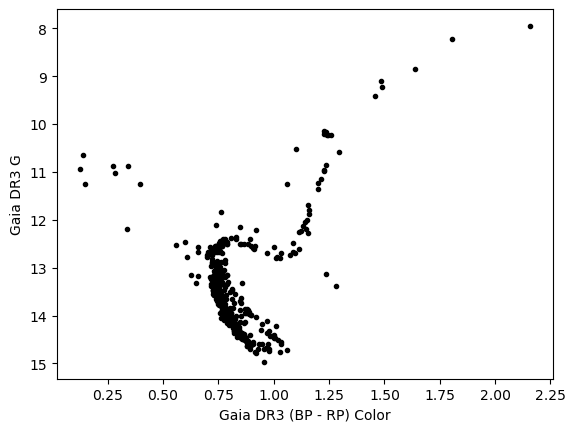

In [5]:
res = cluster_filter(cone_search_radius=2)

fig, ax = plt.subplots()

ax.plot(
    res.phot_bp_mean_mag - res.phot_rp_mean_mag , 
    res.phot_g_mean_mag, 
    marker='.',
    linestyle='none',
    color='k'
)

ax.invert_yaxis()
ax.set_ylabel("Gaia DR3 G")
ax.set_xlabel("Gaia DR3 (BP - RP) Color")

In [ ]:
res